<div style='background-image: url("../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Rate and State Friction Toolkit</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Dashboard</div>
        </div>
    </div>
</div>

Seismo-Live: http://seismo-live.org

##### Authors:
* John Leeman ([@jrleeman](https://github.com/jrleeman), http://www.johnrleeman.com/)

---

<div style="background-color: #FBC02D; padding: 10px">
This is a dashboard demoing the functionality of the [Rate and State Friction Toolkit](https://github.com/jrleeman/rsfmodel). <br><br>

**Two steps to get it going: (1) "Cell -> Run All" (wait until it finishes) and (2) "View -> Dashboard Preview".**
</div>

In [1]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
from rsfmodel import rsf, staterelations, plot

%matplotlib notebook

In [2]:
def RunModel():
    # Set model initial conditions
    model.mu0 = 0.6 # Friction initial (at the reference velocity)
    model.a = a_floatBox.value # Empirical coefficient for the direct effect
    model.k = k_floatBox.value # Normalized System stiffness (friction/micron)

    if sv1_dropdown.value == "Aging Relation":
        state1 = staterelations.DieterichState()
        state1.b = b1_floatBox.value  # Empirical coefficient for the evolution effect
        state1.Dc = Dc1_floatBox.value  # Critical slip distance

    elif sv1_dropdown.value == "Slowness Relation":
        state1 = staterelations.RuinaState()
        state1.b = b1_floatBox.value  # Empirical coefficient for the evolution effect
        state1.Dc = Dc1_floatBox.value  # Critical slip distance

    else:
        # We shouldn't be here!
        pass

    if sv2_dropdown.value == "Aging Relation":
        state2 = staterelations.DieterichState()
        state2.b = b1_floatBox.value  # Empirical coefficient for the evolution effect
        state2.Dc = Dc1_floatBox.value  # Critical slip distance

    elif sv2_dropdown.value == "Slowness Relation":
        state2 = staterelations.RuinaState()
        state2.b = b1_floatBox.value  # Empirical coefficient for the evolution effect
        state2.Dc = Dc1_floatBox.value  # Critical slip distance

    else:
        # None
        pass

    model.state_relations = [state1] # Which state relation we want to use

    if sv2_dropdown.value != "None":
        model.state_relations.append(state2)

    time, velocity = parse_sequence(step_sequence_string.value)

    model.time = time
    # Set the model load point velocity, must be same shape as model.model_time
    model.loadpoint_velocity = velocity

    model.v = velocity[0] # Initial slider velocity, generally is vlp(t=0)
    model.vref = velocity[0] # Reference velocity, generally vlp(t=0)

    # Run the model!
    model.solve()

In [3]:
def update_dispalcement_plot(model):
    #clear_output(wait=True)
    line_lp_mu.set_xdata(model.results.loadpoint_displacement)
    line_lp_mu.set_ydata(model.results.friction)

    line_lp_vs.set_xdata(model.results.loadpoint_displacement)
    line_lp_vs.set_ydata(model.results.slider_velocity)

    ax1.set_xlim(0, np.max(model.results.loadpoint_displacement))

    ax1.relim()
    ax1.autoscale_view(False, False, True)

    ax1b.relim()
    ax1b.autoscale_view(False, False, True)
    fig_vars.canvas.draw()

In [4]:
def update_time_plot(model):
    #clear_output(wait=True)

    line_time_mu.set_xdata(model.results.time)
    line_time_mu.set_ydata(model.results.friction)

    line_time_vs.set_xdata(model.results.time)
    line_time_vs.set_ydata(model.results.slider_velocity)

    ax2.set_xlim(0, np.max(model.results.time))

    ax2.relim()
    ax2.autoscale_view(False, False, True)

    ax2b.relim()
    ax2b.autoscale_view(False, False, True)
    fig_vars.canvas.draw()


In [5]:
def update_phase_plot(model):
    ax3.cla()
    phase_line, = ax3.plot([], [], color=tableau20[4], linewidth=2)

    ax3.set_xlabel(r'ln$\frac{V}{V_{ref}}$', fontsize=16, labelpad=20)
    ax3.set_ylabel(r'$\mu$', fontsize=16)

    v_ratio = np.log(model.results.slider_velocity/model.vref)
    phase_line.set_xdata(v_ratio)
    phase_line.set_ydata(model.results.friction)

    #xlims = ax2.get_xlims()#[np.min(v_ratio), np.max(v_ratio)]
    #ylims = ax3.get_xlims()#[np.min(model.results.friction), np.max(model.results.friction)]
    ax3.relim()
    ax3.autoscale_view(False, True, True)
    ylims = ax3.get_ylim()
    xlims = ax3.get_xlim()
    # Plot lines of constant a that are in the view
    y_line = model.a * np.array(xlims)
    for mu in np.arange(0, ylims[1]*2, 0.005):
        y_line_plot = y_line + mu
        if max(y_line_plot) > ylims[0]:
            ax3.plot([xlims[0], xlims[1]], y_line_plot, color='k', linestyle='--')

    # Plot a line of rate dependence "Steady State Line"
    state_b_sum = 0
    for state in model.state_relations:
        state_b_sum += state.b
        mu_rate_dependence = model.mu0 + (model.a - state_b_sum)*np.array(xlims)
        ax3.plot(xlims, mu_rate_dependence, color='k', linestyle='--')

    ax3.set_xlim(xlims)
    ax3.set_ylim(ylims)
    #ax3.relim()
    #ax3.autoscale_view(False, True, True)
    fig_phase.canvas.draw()

In [6]:
def stiffness_text_update(model):
    kc = (model.state_relations[0].b - model.a)/model.state_relations[0].Dc
    kc_label.value = "k$_c$ [$\mu$m$^{-1}$]: %f" %kc
    kappa_label.value = "k/k$_c$: %f" %(model.k/kc)

In [7]:
def parse_sequence(seqString):
    steps = seqString.split(',')
    if len(steps)%2 != 0:
        # Odd number of steps is an error!
        step_sequence_string.border_color = 'red'
    else:
        step_sequence_string.border_color = 'green'
        steps = np.array(steps)
        steps = steps.astype(int)

        steps = steps.reshape((int(len(steps)/2),2))

        dt = 0.01

        if simType_buttons.value == 'Velocity-Displacement':
            velocity = np.array([])
            time = np.arange(0, np.sum(steps[:,1]/steps[:,0]), dt)
            for step_velocity, step_displacement in steps:
                step_time = step_displacement/step_velocity
                velocity = np.hstack((velocity, np.ones(int(step_time/dt)) * step_velocity))

        if simType_buttons.value == 'Velocity-Time':
            velocity = np.array([])
            time = np.arange(0, np.sum(steps[:,1]), dt)
            for step_velocity, step_time in steps:
                velocity = np.hstack((velocity, np.ones(int(step_time/dt)) * step_velocity))

        return time, velocity

In [8]:
def on_calculate_clicked(button):
    RunModel()
    update_dispalcement_plot(model)
    update_time_plot(model)
    update_phase_plot(model)
    stiffness_text_update(model)
    clear_output(wait=True)


In [9]:
def on_reset(button):
    a_floatBox.value = 0.005
    b1_floatBox.value = 0.01
    Dc1_floatBox.value = 10.
    b2_floatBox.value = 0.01
    Dc2_floatBox.value = 10.
    k_floatBox.value = 1e-3
    sv1_dropdown.value = "Aging Relation"
    sv2_dropdown.value = "None"
    RunModel()
    update_plot()

In [10]:
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [11]:
model = rsf.Model()

In [12]:
a_floatBox = widgets.BoundedFloatText(
    value=0.005,
    min=0,
    max=1,
    description='a:',
)

b1_floatBox = widgets.BoundedFloatText(
    value=0.01,
    min=0,
    max=1,
    description='b:',
)

b2_floatBox = widgets.BoundedFloatText(
    value=0.01,
    min=0,
    max=1,
    description='b:',
)

Dc1_floatBox = widgets.BoundedFloatText(
    value=10.0,
    min=0,
    max=30000.0,
    description='Dc:',
)

Dc2_floatBox = widgets.BoundedFloatText(
    value=10.0,
    min=0,
    max=30000.0,
    description='Dc:',
)

k_floatBox = widgets.BoundedFloatText(
    value=1e-3,
    min=0.,
    max=100,
    description='k:',
)

sv1_dropdown = widgets.Dropdown(
    options=['Aging Relation', 'Slowness Relation'],
    value='Aging Relation',
    decription='State Relation:')

sv2_dropdown = widgets.Dropdown(
    options=['None', 'Aging Relation', 'Slowness Relation'],
    value='None',
    decription='State Relation:')

simType_buttons = widgets.ToggleButtons(
    description='Simulation Type',
    options=['Velocity-Displacement', 'Velocity-Time'])

calculate_button = widgets.Button(
    description="Calculate")

reset_button = widgets.Button(
    description="Reset")

step_sequence_string = widgets.Text(
    description='Sequence:',
    value='1,10,10,200',
)

In [13]:
sv1_label = widgets.Label(
    value="First State Variable",
)

sv2_label = widgets.Label(
    value="Second State Variable",
)

kc_label = widgets.Label(
    value="k$_c$ [$\mu$m$^{-1}$]: "
)

kappa_label = widgets.Label(
    value="k/k$_c$: "
)

In [14]:
display(kc_label, kappa_label)

Label(value='k$_c$ [$\\mu$m$^{-1}$]: ')

Label(value='k/k$_c$: ')

In [15]:
display(calculate_button, reset_button)

Button(description='Calculate', style=ButtonStyle())

Button(description='Reset', style=ButtonStyle())

In [16]:
def state_of_sv2():
    if sv2_dropdown.value == "None":
        b2_floatBox.disabled =  True
        Dc2_floatBox.disabled =  True
    else:
        b2_floatBox.disabled = False
        Dc2_floatBox.disabled = False

In [17]:
calculate_button.on_click(on_calculate_clicked)
reset_button.on_click(on_reset)
sv2_dropdown.on_trait_change(state_of_sv2)
b2_floatBox.disabled = True
Dc2_floatBox.disabled = True

/Users/lion/miniconda3/envs/seismo_live/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
display(k_floatBox, a_floatBox)

BoundedFloatText(value=0.001, description='k:')

BoundedFloatText(value=0.005, description='a:', max=1.0)

In [19]:
display(sv1_label, sv1_dropdown, b1_floatBox, Dc1_floatBox)

Label(value='First State Variable')

Dropdown(options=('Aging Relation', 'Slowness Relation'), value='Aging Relation')

BoundedFloatText(value=0.01, description='b:', max=1.0)

BoundedFloatText(value=10.0, description='Dc:', max=30000.0)

In [20]:
display(sv2_label, sv2_dropdown, b2_floatBox, Dc2_floatBox)

Label(value='Second State Variable')

Dropdown(options=('None', 'Aging Relation', 'Slowness Relation'), value='None')

BoundedFloatText(value=0.01, description='b:', disabled=True, max=1.0)

BoundedFloatText(value=10.0, description='Dc:', disabled=True, max=30000.0)

In [21]:
display(simType_buttons)
display(step_sequence_string)

ToggleButtons(description='Simulation Type', options=('Velocity-Displacement', 'Velocity-Time'), value='Veloci…

Text(value='1,10,10,200', description='Sequence:')

Text(0, 0.5, '$\\mu$')

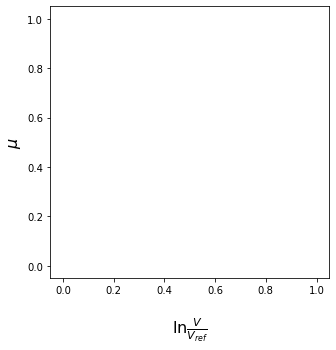

In [22]:
# Setup figure and axes
# Generally plots is ~1.33x width to height (10,7.5 or 12,9)
fig_phase = plt.figure(figsize=(5,5))
ax3 = plt.subplot(111)

phase_line, = ax3.plot([], [], color=tableau20[4], linewidth=2)

ax3.set_xlabel(r'ln$\frac{V}{V_{ref}}$', fontsize=16, labelpad=20)
ax3.set_ylabel(r'$\mu$', fontsize=16)

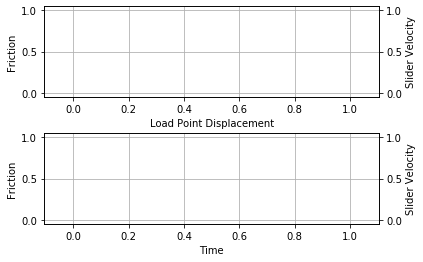

In [23]:
# Setup figure and axes
# Generally plots is ~1.33x width to height (10,7.5 or 12,9)
fig_vars = plt.figure()
ax1 = plt.subplot(211)
ax1b = ax1.twinx()

ax2 = plt.subplot(212)
ax2b = ax2.twinx()

# Set labels and tick sizes
ax1.set_xlabel(r'Load Point Displacement')
ax1.set_ylabel(r'Friction')
ax1b.set_ylabel(r'Slider Velocity')

# Plotting
line_lp_mu, = ax1.plot([], [], color=tableau20[0], linewidth=2)
line_lp_vs, = ax1b.plot([], [], color=tableau20[2], linewidth=1, linestyle='--')

ax1.grid()

# Set labels and tick sizes
ax2.set_xlabel(r'Time')
ax2.set_ylabel(r'Friction')
ax2b.set_ylabel(r'Slider Velocity')

# Plotting
line_time_mu, = ax2.plot([], [], color=tableau20[0], linewidth=2)
line_time_vs, = ax2b.plot([], [], color=tableau20[2], linewidth=1, linestyle='--')

ax2.grid()

plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [24]:
# Run the defaults to have some output showing when we load
on_calculate_clicked(calculate_button)